In [1]:
import os
import gc
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import ConcatDataset, random_split, DataLoader

In [2]:
# Setup the device to be used for training and evaluation
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    x = torch.ones(1, device=DEVICE)
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    x = torch.ones(1, device=DEVICE)
    print("Using Apple Metal Performance Shaders (MPS) device.")
else:
    DEVICE = torch.device("cpu")
    print("No GPU found. Defaulting to CPU.")

Using Apple Metal Performance Shaders (MPS) device.


# Config

In [3]:
from utils import JupyterArgParser
from pathlib import Path

# ========= global settings =========
# Taken from i2sb paper with minor changes

RESULT_DIR = Path("results")

# --------------- basic ---------------
parser = JupyterArgParser()
parser.add_argument("--seed",           type=int,   default=0)
parser.add_argument("--name",           type=str,   default=None,        help="experiment ID")
parser.add_argument("--ckpt",           type=str,   default=None,        help="resumed checkpoint name")
parser.add_argument("--device",         type=str,   default=DEVICE,      help="type of device to use for training")
parser.add_argument("--gpu",            type=int,   default=None,        help="set only if you wish to run on a particular GPU")

# --------------- model ---------------
parser.add_argument("--image-size",     type=int,   default=224)
parser.add_argument("--t0",             type=float, default=1e-4,        help="sigma start time in network parametrization")
parser.add_argument("--T",              type=float, default=1.,          help="sigma end time in network parametrization")
parser.add_argument("--interval",       type=int,   default=1000,        help="number of interval")
parser.add_argument("--beta-max",       type=float, default=0.3,         help="max diffusion for the diffusion model")
parser.add_argument("--beta-schedule",  type=str,   default="i2sb",    help="schedule for beta")
parser.add_argument("--ot-ode",         action="store_true",             help="use OT-ODE model")
parser.add_argument("--clip-denoise",   action="store_true",             help="clamp predicted image to [-1,1] at each")
parser.add_argument("--use-fp16",       action="store_true",             help="use fp16 for training")
parser.add_argument("diffusion-type",   type=str,   default="schrodinger_bridge",      help="type of diffusion model")

# --------------- optimizer and loss ---------------
parser.add_argument("--batch-size",     type=int,   default=256)
parser.add_argument("--microbatch",     type=int,   default=4,           help="accumulate gradient over microbatch until full batch-size")
parser.add_argument("--num-itr",        type=int,   default=1002,     help="training iteration")
parser.add_argument("--lr",             type=float, default=5e-5,        help="learning rate")
parser.add_argument("--lr-gamma",       type=float, default=0.99,        help="learning rate decay ratio")
parser.add_argument("--lr-step",        type=int,   default=1000,        help="learning rate decay step size")
parser.add_argument("--l2-norm",        type=float, default=0.0)
parser.add_argument("--ema",            type=float, default=0.99)

# --------------- path and logging ---------------
parser.add_argument("--dataset-dir",    type=Path,  default="/dataset",  help="path to LMDB dataset")
parser.add_argument("--log-dir",        type=Path,  default=".log",      help="path to log std outputs and writer data")
parser.add_argument("--log-writer",     type=str,   default=None,        help="log writer: can be tensorbard, wandb, or None")
parser.add_argument("--wandb-api-key",  type=str,   default=None,        help="unique API key of your W&B account; see https://wandb.ai/authorize")
parser.add_argument("--wandb-user",     type=str,   default=None,        help="user name of your W&B account")
parser.add_argument("--ckpt-path",      type=Path,  default=None,        help="path to save checkpoints")
parser.add_argument("--load",           type=Path,  default=None,        help="path to load checkpoints")
parser.add_argument("--unet_path",      type=str,   default=None,        help="path of UNet model to load for training")

# --------------- distributed ---------------
parser.add_argument("--local-rank",     type=int,   default=0)
parser.add_argument("--global-rank",    type=int,   default=0)
parser.add_argument("--global-size",    type=int,   default=1)

opt = parser.get_options()
# ========= path handle =========
opt.name = "test"
os.makedirs(opt.log_dir, exist_ok=True)
opt.ckpt_path = RESULT_DIR / opt.name if opt.name else RESULT_DIR / "temp"
os.makedirs(opt.ckpt_path, exist_ok=True)

if opt.ckpt:
    ckpt_file = RESULT_DIR / opt.ckpt / "latest.pt"
    assert ckpt_file.exists()
    opt.load = ckpt_file
else:
    opt.load = None

# ========= auto assert =========
assert opt.batch_size % opt.microbatch == 0, f"{opt.batch_size=} is not dividable by {opt.microbatch}!"



# Prepare Data

In [4]:
# Dataset creation from 1 npy file
'''
from data import SuperResolutionDataset

# build dataset    
hr_latent_path = 'data/one_meter_naip/224naip_latent_dataset_drone.npy'
lr_latent_path = 'data/one_meter_naip/224naip_latent_dataset_satellite.npy'
hr_latent = np.load(hr_latent_path, mmap_mode='r') # shape (B, C, H, W)
lr_latent = np.load(lr_latent_path, mmap_mode='r')
assert len(hr_latent) == len(lr_latent), f"hr_latent b={hr_latent.shape[0]} and lr_latent b={lr_latent.shape[0]} don't have the same B"
print(f"hr_latent shape: {hr_latent.shape}")
print("hr_latent  min/max:", hr_latent.min(), hr_latent.max())
print("lr_latent  min/max:", lr_latent.min(), lr_latent.max())

B = len(hr_latent)
split = int(0.9*B) # 90:10 train:test split

# shuffle loaded data before split
rng = np.random.default_rng(seed=42)
perm = rng.permutation(B)
train_idx = perm[:split]
val_idx = perm[split:]

train_hr, val_hr = hr_latent[train_idx], hr_latent[val_idx]
train_lr, val_lr = lr_latent[train_idx], lr_latent[val_idx]

train = SuperResolutionDataset(hr_images=train_hr, lr_images=train_lr, transform=None)
val = SuperResolutionDataset(hr_images=val_hr, lr_images=val_lr, transform=None)
print(f"Dataset lengths: train={len(train)} val={len(val)}")
'''

'\nfrom data import SuperResolutionDataset\n\n# build dataset    \nhr_latent_path = \'data/one_meter_naip/224naip_latent_dataset_drone.npy\'\nlr_latent_path = \'data/one_meter_naip/224naip_latent_dataset_satellite.npy\'\nhr_latent = np.load(hr_latent_path, mmap_mode=\'r\') # shape (B, C, H, W)\nlr_latent = np.load(lr_latent_path, mmap_mode=\'r\')\nassert len(hr_latent) == len(lr_latent), f"hr_latent b={hr_latent.shape[0]} and lr_latent b={lr_latent.shape[0]} don\'t have the same B"\nprint(f"hr_latent shape: {hr_latent.shape}")\nprint("hr_latent  min/max:", hr_latent.min(), hr_latent.max())\nprint("lr_latent  min/max:", lr_latent.min(), lr_latent.max())\n\nB = len(hr_latent)\nsplit = int(0.9*B) # 90:10 train:test split\n\n# shuffle loaded data before split\nrng = np.random.default_rng(seed=42)\nperm = rng.permutation(B)\ntrain_idx = perm[:split]\nval_idx = perm[split:]\n\ntrain_hr, val_hr = hr_latent[train_idx], hr_latent[val_idx]\ntrain_lr, val_lr = lr_latent[train_idx], lr_latent[val_

In [5]:
# Dataset creation from list of npy files
from data import SuperResolutionDataset

hr_latent_paths = [
  'data/one_meter_naip/224naip_latent_dataset_drone_V1.npy',
  'data/one_meter_naip/224naip_latent_dataset_drone_V2.npy'
]
lr_latent_paths = [
  'data/one_meter_naip/224naip_latent_dataset_satellite_V1.npy',
  'data/one_meter_naip/224naip_latent_dataset_satellite_V2.npy'
]

subdatasets = []

for hr_f, lr_f in zip(hr_latent_paths, lr_latent_paths):
  hr_mem = np.load(hr_f, mmap_mode='r')
  lr_mem = np.load(lr_f, mmap_mode='r')
  subdatasets.append(
    SuperResolutionDataset(hr_mem, lr_mem, transform=None)
  )

full = ConcatDataset(subdatasets) # wrapper that routes indices to sub-datasets
total = len(full)
print(f"combined dataset has length={total}")
n_train = int(0.9*total)
n_val = total - n_train

train, val = random_split(
    full,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
) # returns 2 subset objects. each subset object holds list of indices into full

print(f"train length: {len(train)}, val length:{len(val)}")

combined dataset has length=143253
train length: 128927, val length:14326


In [6]:
from i2sb.runner import Runner

# build runner
run = Runner(opt)
# print(run.net)

# train
train_loss, eval_loss = run.train(opt, train, val)


/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Built schrodinger_bridge Diffusion Model with 1000 steps and i2sb beta schedule!


train_inner_loop:   0%|          | 0/64 [00:00<?, ?it/s]/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 71.84it/s]


train_it 1/1002 | lr:5.00e-05 | noise_prediction_loss:+153.6967
Saved weights and losses on iteration 0


eval_inner_loop: 100%|██████████| 64/64 [01:20<00:00,  1.25s/it]


EVALUATE: eval_it 1/1002 | noise_prediction_loss:+109.1735 | reconstruction_loss:+23.8171


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 139.56it/s]


train_it 2/1002 | lr:5.00e-05 | noise_prediction_loss:+111.7015


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 139.07it/s]


train_it 3/1002 | lr:5.00e-05 | noise_prediction_loss:+79.4468


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 137.32it/s]


train_it 4/1002 | lr:5.00e-05 | noise_prediction_loss:+55.6047


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 114.63it/s]


train_it 5/1002 | lr:5.00e-05 | noise_prediction_loss:+39.8612


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 90.32it/s]


train_it 6/1002 | lr:5.00e-05 | noise_prediction_loss:+29.6192


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 135.82it/s]


train_it 7/1002 | lr:5.00e-05 | noise_prediction_loss:+20.7311


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 97.94it/s] 


train_it 8/1002 | lr:5.00e-05 | noise_prediction_loss:+17.7296


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 96.79it/s] 


train_it 9/1002 | lr:5.00e-05 | noise_prediction_loss:+13.7910


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 135.54it/s]


train_it 10/1002 | lr:5.00e-05 | noise_prediction_loss:+13.8047


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 86.75it/s]


train_it 51/1002 | lr:5.00e-05 | noise_prediction_loss:+1.5434


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 79.46it/s]


train_it 101/1002 | lr:5.00e-05 | noise_prediction_loss:+0.7631


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 97.93it/s] 


train_it 151/1002 | lr:5.00e-05 | noise_prediction_loss:+0.5927


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 90.51it/s]


train_it 201/1002 | lr:5.00e-05 | noise_prediction_loss:+0.5587


eval_inner_loop: 100%|██████████| 64/64 [01:27<00:00,  1.37s/it]


EVALUATE: eval_it 201/1002 | noise_prediction_loss:+0.5501 | reconstruction_loss:+0.1542


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 94.86it/s] 


train_it 251/1002 | lr:5.00e-05 | noise_prediction_loss:+0.5322


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 84.87it/s]


train_it 301/1002 | lr:5.00e-05 | noise_prediction_loss:+0.4856


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 89.46it/s] 


train_it 351/1002 | lr:5.00e-05 | noise_prediction_loss:+0.5534


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 83.71it/s]


train_it 401/1002 | lr:5.00e-05 | noise_prediction_loss:+0.4714


eval_inner_loop: 100%|██████████| 64/64 [01:36<00:00,  1.51s/it]


EVALUATE: eval_it 401/1002 | noise_prediction_loss:+0.5117 | reconstruction_loss:+0.1406


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 87.73it/s]


train_it 451/1002 | lr:5.00e-05 | noise_prediction_loss:+0.5035


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 83.35it/s]


train_it 501/1002 | lr:5.00e-05 | noise_prediction_loss:+0.4773


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 80.22it/s]


train_it 551/1002 | lr:5.00e-05 | noise_prediction_loss:+0.5129


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 83.22it/s]


train_it 601/1002 | lr:5.00e-05 | noise_prediction_loss:+0.4636


eval_inner_loop: 100%|██████████| 64/64 [01:43<00:00,  1.61s/it]


EVALUATE: eval_it 601/1002 | noise_prediction_loss:+0.5117 | reconstruction_loss:+0.1366


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 89.12it/s]


train_it 651/1002 | lr:5.00e-05 | noise_prediction_loss:+0.5112


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 81.96it/s]


train_it 701/1002 | lr:5.00e-05 | noise_prediction_loss:+0.5045


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 89.61it/s] 


train_it 751/1002 | lr:5.00e-05 | noise_prediction_loss:+0.4667


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 86.56it/s]


train_it 801/1002 | lr:5.00e-05 | noise_prediction_loss:+0.4944


eval_inner_loop: 100%|██████████| 64/64 [01:39<00:00,  1.56s/it]


EVALUATE: eval_it 801/1002 | noise_prediction_loss:+0.5013 | reconstruction_loss:+0.1339


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 78.83it/s]


train_it 851/1002 | lr:5.00e-05 | noise_prediction_loss:+0.5110


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 85.56it/s]


train_it 901/1002 | lr:5.00e-05 | noise_prediction_loss:+0.5001


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 90.72it/s]


train_it 951/1002 | lr:5.00e-05 | noise_prediction_loss:+0.4905


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 81.59it/s]


train_it 1001/1002 | lr:4.95e-05 | noise_prediction_loss:+0.5194
Saved weights and losses on iteration 1000


eval_inner_loop: 100%|██████████| 64/64 [01:40<00:00,  1.57s/it]


EVALUATE: eval_it 1001/1002 | noise_prediction_loss:+0.5003 | reconstruction_loss:+0.1315
Saved weights and losses on iteration 1001


In [7]:
del run
del train, val
gc.collect()

678

In [8]:
t_noise_pred_l = np.load('results/test/train_losses.npy')
ti = np.arange(0, len(t_noise_pred_l))

e = np.load('results/test/eval_losses.npy')
ei = e[:, 0].astype(int)
e_noise_pred_l = e[:, 1]
e_reconstruction_l = e[:, 2]

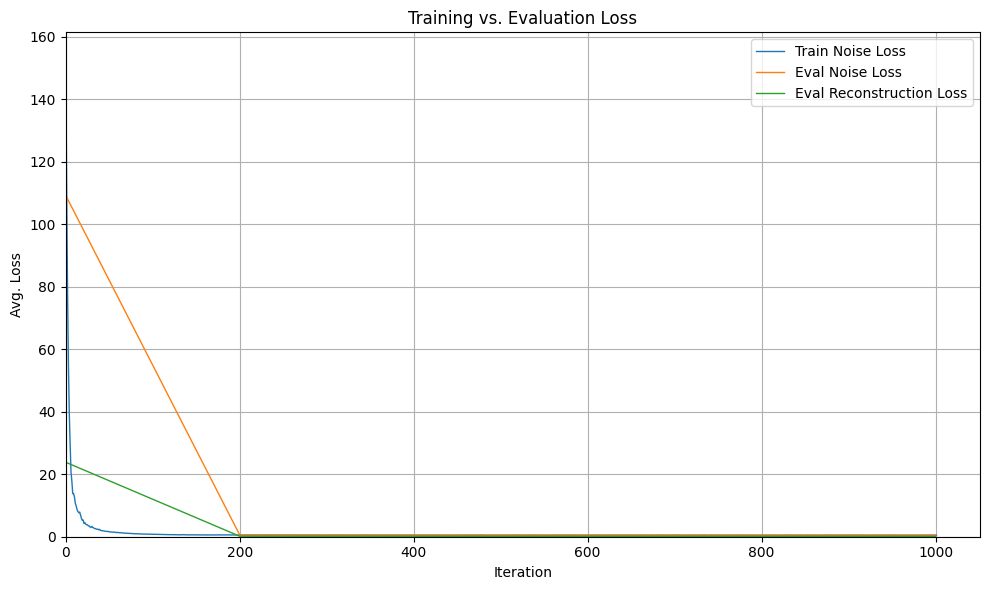

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(ti, t_noise_pred_l, label='Train Noise Loss', linewidth=1)
plt.plot(ei, e_noise_pred_l, label='Eval Noise Loss', linewidth=1)
plt.plot(ei, e_reconstruction_l, label='Eval Reconstruction Loss', linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Avg. Loss')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Training vs. Evaluation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

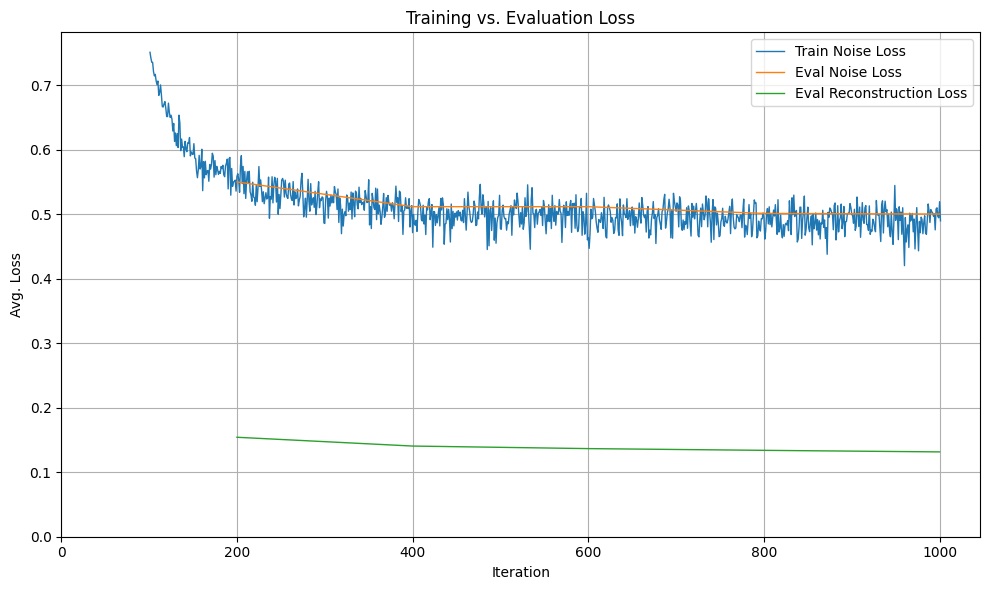

In [10]:
mask_t = ti > 100
mask_e = ei > 100

ti_masked = ti[mask_t]
t_noise_pred_l_masked = t_noise_pred_l[mask_t]
ei_masked = ei[mask_e]
e_noise_pred_l_masked = e_noise_pred_l[mask_e]
e_reconstruction_l_masked = e_reconstruction_l[mask_e]

plt.figure(figsize=(10, 6))
plt.plot(ti_masked, t_noise_pred_l_masked, label='Train Noise Loss', linewidth=1)
plt.plot(ei_masked, e_noise_pred_l_masked, label='Eval Noise Loss', linewidth=1)
plt.plot(ei_masked, e_reconstruction_l_masked, label='Eval Reconstruction Loss', linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Avg. Loss')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Training vs. Evaluation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# # Image transition plotter
# # source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

# torch.manual_seed(opt.seed)
# def plot_images(imgs, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs[0], list):
#         # Make a 2d grid even if there's just 1 row
#         imgs = [imgs]

#     num_rows = len(imgs)
#     num_cols = len(imgs[0]) + with_orig
#     _, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
#     for row_idx, row in enumerate(imgs):
#         for col_idx, img in enumerate(row):
#             ax = axs[row_idx, col_idx]
#             ax.imshow(np.asarray(img), **imshow_kwargs)
#             ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
#     if row_title is not None:
#         for row_idx in range(num_rows):
#             axs[row_idx, 0].set(ylabel=row_title[row_idx])

#     plt.tight_layout()